In [1]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import pandas as pd
import numpy as np
import string
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, Dataset
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification

In [2]:
train = pd.read_pickle('Preprocessing_Train.pkl')
stop_words = stopwords.words('english')
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained(
    "bert-base-uncased",
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.       
    )

def bert_tokenize(doc, tokenizer=tokenizer):
    
    tokens = re.split(r'\s', doc.lower())
    tokens = [i for i in tokens if i not in stop_words]
    tokens = [i for i in tokens if len(re.findall(r'\w', i)) >= 2]
    tokens = [re.findall(r"\w[a-zA-Z0-9.-]*\w", i)[0] for i in tokens if re.findall(r"\w[a-zA-Z0-9.-]*\w", i)]
    result = []
    for i in tokens:
        result += tokenizer.convert_tokens_to_ids(tokenizer.tokenize(i))
        
    return result

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
X = train.document_text.apply(bert_tokenize)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, train.label, test_size=0.25)

In [5]:
## Create a Pytorch Dataset class to convert data to tensors
## Each token index list is set to the same length, 1024 by default
## The shorter one would be padded with 0, and the longer one would be truncated

class dataset_(Dataset):
    
    def __init__(self, X, y, max_len=1200):
        super(dataset_, self).__init__()
        pad = [i[:max_len] + [0]*(max_len-len(i[:max_len])) for i in X]
        self.X = torch.tensor(pad, dtype=torch.int32)
        self.y = torch.Tensor(np.array(list(y)))
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
train_ = dataset_(X_train, y_train)
test_ = dataset_(X_test, y_test)

In [6]:
pretrained_layer = bert_model.get_input_embeddings()

for param in pretrained_layer.parameters():
    param.requires_grad=False

# class PE(nn.Module): 

#     def __init__(self, dim_emb=256, dropout=0.5, max_len=1024): 
#         super(PE, self).__init__() 
#         self.dropout = nn.Dropout(dropout) 
#         pe = torch.zeros(max_len, dim_emb) 
#         position = torch.arange(0, max_len).unsqueeze(1) 
#         div_term = torch.exp(-math.log(10000) * torch.arange(0, dim_emb, 2)/dim_emb)
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term) 
#         pe = pe.unsqueeze(0) 
#         self.register_buffer('pe', pe) 
        
#     def forward(self, x): 
#         x = x + Variable(self.pe[:, :], requires_grad=False) 
#         return self.dropout(x) 

    
class Att(nn.Module):
    
    def __init__(self, dim_emb=512):
        super(Att, self).__init__()
        self.Wq = nn.Linear(dim_emb, 50, bias=False)
        self.Wk = nn.Linear(768, dim_emb, bias=False)
        self.Wv = nn.Linear(768, dim_emb, bias=False)

    def forward(self, x): ## (1200, 768)
        K = self.Wk(x) ## (1200, dim_emb)
        V = self.Wv(x)
        temp = self.Wq(K) ## (1200, 50)
        score = temp.transpose(-2, -1) / math.sqrt(K.size(-1)) ## (50, 1200)
        return torch.matmul(nn.Softmax(dim=-1)(score), V)
    
    
class LN(nn.Module):
    
    def __init__(self, dim_emb=512):
        super(LN, self).__init__()
        self.feed = nn.LayerNorm(dim_emb)

    def forward(self, x):
        return x + self.feed(x)


class final_model(nn.Module):
    
    def __init__(self, dim_emb=512, dropout=0.3):
        super(final_model, self).__init__()
        self.net = nn.Sequential(
            pretrained_layer,
            # PE(dim_emb, dropout, max_len),  ## (1200, 768)
            # nn.Dropout(dropout),
            Att(dim_emb),  ## (50, dim_emb)
            LN(dim_emb),
            nn.Linear(dim_emb, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid())
            
    def forward(self, x):
        return self.net(x)

In [7]:
def train_model(model, train_dataset, eval_dataset, device, norm=0.5,
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'eval_loss': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=512)

    model = model.to(device)
    if norm:
        Loss = nn.BCELoss(weight=train_.y.sum(axis=0)**-norm).to(device)
    else:
        Loss = nn.BCELoss().to(device)
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        eval_loss = 0
        pred = []
        real = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X).squeeze(-1)
            loss = Loss(out, y)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            
        model.eval()
        with torch.no_grad():
            for X, y in eval_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X).squeeze(-1)
                loss = Loss(out, y)
                eval_loss += loss
                pred.append(out.cpu())
                real.append(y.cpu())
                
        train_loss = (train_loss/len(train_loader)).item()
        eval_loss = (eval_loss/len(eval_loader)).item() 
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)  
        
        if not (epoch+1)%50:
            res = torch.cat(pred)
            tru = torch.cat(real)
            print(f'\nepoch {epoch+1}:\n')
            print(classification_report(tru.view(-1), np.round(res).view(-1)))
            print(f'\nSpent time: {time.time()-start} seconds')
            
        
    print('Training complete!')
    
    
    return history

In [8]:
mod = final_model(dim_emb=384)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
norm = None
epochs = 150
lr = 0.00027
batch_size = 128
# weight_decay = 0.0003
hist = train_model(mod, train_, test_, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

Training start!

epoch 50:

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96    111637
         1.0       0.73      0.26      0.38     11613

    accuracy                           0.92    123250
   macro avg       0.83      0.62      0.67    123250
weighted avg       0.91      0.92      0.90    123250


Spent time: 138.9654188156128 seconds

epoch 100:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    111637
         1.0       0.78      0.51      0.61     11613

    accuracy                           0.94    123250
   macro avg       0.87      0.75      0.79    123250
weighted avg       0.93      0.94      0.93    123250


Spent time: 275.6994047164917 seconds

epoch 150:

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    111637
         1.0       0.77      0.61      0.68     11613

    accuracy                           0.95    123

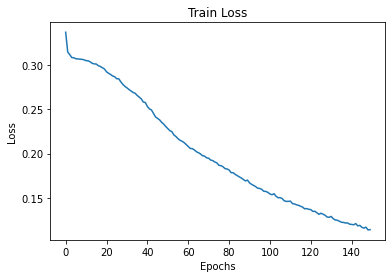

In [9]:
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss']);

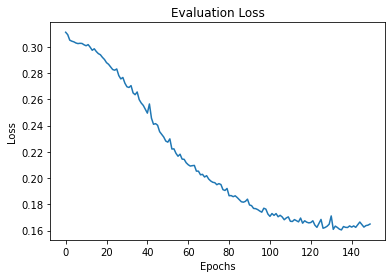

In [10]:
plt.title('Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss']);

In [25]:
with torch.no_grad():
    res = mod.cpu()(test_.X).squeeze(-1)

acc = (test_.y.view(-1) == np.round(res).view(-1)).float().mean().item()
print(acc)

print(classification_report(test_.y.view(-1), np.round(res).view(-1)))

0.9491845965385437
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    111482
         1.0       0.74      0.73      0.73     11768

    accuracy                           0.95    123250
   macro avg       0.85      0.85      0.85    123250
weighted avg       0.95      0.95      0.95    123250



In [8]:
tst = pd.read_csv('datasolve-us/test.csv')

t = tst.apply(lambda x: x['name']+' '+x['document_text'], axis=1)

_, tk = get_voc_new(t, False, True)

tk = word2idx(tk)
pad_t = [i[:896] + [0]*(896-len(i[:896])) for i in tk]
t_ = torch.tensor(pad_t, dtype=torch.int32)

In [10]:
with torch.no_grad():
    pd.DataFrame(np.round(mod(t_).squeeze(-1)).view(-1)).to_csv('try_2.csv')

In [100]:
# torch.save(mod, 'rd_init_complex.pt')

In [11]:
t1 = pd.read_csv('try_1.csv')
t2 = pd.read_csv('try_2.csv')

In [13]:
t1.predictions

0         1
1         0
2         1
3         0
4         0
         ..
249645    0
249646    0
249647    0
249648    0
249649    0
Name: predictions, Length: 249650, dtype: int64

In [17]:
(t2['0'] == t1.predictions).mean()

0.9474103745243341